<a href="https://colab.research.google.com/github/Nicordaro/Project_MLDL/blob/master/cosine_normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Cloning files needed*

In [1]:
import os
# Clone github repository with data
# if os.path.isdir('./Project_MLDL'):
!rm -rf Project_MLDL
if not os.path.isdir('./CIFAR100_tError'):
  !git clone https://github.com/Nicordaro/Project_MLDL


Cloning into 'Project_MLDL'...
remote: Enumerating objects: 118, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (118/118), done.
remote: Total 547 (delta 71), reused 0 (delta 0), pack-reused 429
Receiving objects: 100% (547/547), 1.60 MiB | 3.69 MiB/s, done.
Resolving deltas: 100% (309/309), done.


**Imports**

---

In [2]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import time
import gc
import seaborn as sns




from PIL import Image
from Project_MLDL.point4.modified_resnet import CosineLinear
from Project_MLDL.confusion_matrix import *
from Project_MLDL.CIFAR100_tError import CIFAR100_tError
from Project_MLDL.model_finetuning import ResNet18
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn
from torchvision import transforms
from torchvision.models import resnet18
from torchvision.models import resnet34
from tqdm import tqdm

# Garbage collector
gc.enable()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Arguments**

---





In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

# Init at 10 because first train is on 10 classes
NUM_CLASSES = 10

# Used for the pseudorandom shuffle of the split
SEED = 12

BATCH_SIZE = 128     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 2         # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 1e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 70     # Total number of training epochs (iterations over dataset)
MILESTONES = [48, 62]  # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.2          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 50

**Transformations definition**

---



In [0]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), # Randomly flip the image with probability of 0.5
                                      transforms.Pad(4), # Add padding
                                      transforms.RandomCrop(32),# Crops a random squares of the image
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) 
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))                                 
])
eval_transform = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))                                 
])
exemplar_transform = transforms.Compose([transforms.RandomHorizontalFlip(), # Randomly flip the image with probability of 0.5
                                      transforms.Pad(4), # Add padding
                                      transforms.RandomCrop(32),# Crops a random squares of the image
                                      transforms.ToTensor() # Turn PIL Image to torch.Tensor
])

*New label function*

In [0]:
DATA_DIR = './CIFAR100'

lbls = [i for i in range(0,100)]  #Array of classes integer-encoded (?)
random.seed(SEED)
random.shuffle(lbls)

def make_data_labels(lbls):     #After shuffle, take first 10 classes, and remove the first 10 from the list passed as argument
    new_labels=[]
    for el in lbls[:10]:
        new_labels.append(el)
    lbls = lbls[10:]

    return lbls, new_labels

In [0]:
from torch.utils.data import Dataset
"""
Take 2 datasets and combine them
"""
class joint_dataset(Dataset):
    
    def __init__(self,d1,d2):
        self.l1 = len(d1)
        self.l2 = len(d2)
        self.d1 = d1
        self.d2 = d2
    def __getitem__(self,index):
        if index>=self.l1:
            image,label = self.d2[index-self.l1]
            image = exemplar_transform(image) # Apply transformations to images
            return image,label
        else:
            image,label = self.d1[index]
            return image,label
    def __len__(self):
        return (self.l1 + self.l2)
        

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import copy
from torch.autograd import Variable

class iCaRL(nn.Module):
  def __init__(self):
    super(iCaRL, self).__init__()

    # CNN with 100 neurons in the last layer (Features Extractor + FC)
    self.net = ResNet18()
    self.net.linear = CosineLinear(512, 100)
    
    # Classification and Distillation losses
    self.cls_loss = nn.BCEWithLogitsLoss()
    self.dist_loss = nn.BCELoss()
    
    self.exemplar_sets=[] # List of exemplar sets, one for each class
    self.exemplars_means=[] # List of exemplar means, one for each exemplar set

  def classify(self, x):
    with torch.no_grad():
      net = self.net.eval()
      output = net(x).argmax(dim=-1)
      return output

  def reduce_exemplar_sets(self,m):
    for y, P_y in enumerate(self.exemplar_sets):
      m = int(m)
      self.exemplar_sets[y] = P_y[:m] # keep only the first m exemplars
  
  def construct_exemplar_set(self,X,m):
    
    # X dataset containing all elements of class y

    torch.no_grad()
    torch.cuda.empty_cache()
    gc.collect()

    feature_extractor = self.net.to(DEVICE)
    feature_extractor.train(False)
    loader = DataLoader(X,batch_size=BATCH_SIZE,shuffle=True,drop_last=False,num_workers = 4) # create dataloader

    features = []
    
    for images,labels in loader:
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)
      feature = feature_extractor.extract_features(images)
      features.append(feature)
      del images
      del labels
      del feature
        
    features_stacked = torch.cat(features) # (num_elements,num_features)
    mean = features_stacked.mean(0) #(num_features)
    mean = torch.stack([mean]*features_stacked.size()[0])  # (num_elements,num_features)
    torch.cuda.empty_cache()
    P = [] # exemplar set
    extracted_features = []

    summa = torch.zeros(1,features_stacked.size()[1]).to(DEVICE) #(1,num_features)
    
    for k in range(1,int(m+1)):
      s = torch.cat([summa]*features_stacked.size()[0]) #(num_elements,num_features)
      index = torch.argmin((mean-(1/k)*(features_stacked+s)).pow(2).sum(1),dim=0)
      features_stacked[index] = features_stacked[index]*100
      pk = X[index.item()][0].unsqueeze(dim=0) # take the image, leave the label
      P.append(pk)
      phipk =  feature_extractor.extract_features(pk.to(DEVICE))
      summa = summa + phipk # update sum of features
      del pk 
   
    #Clear Memory
    del summa
    del features
    del features_stacked
    del mean
    del s
    del feature_extractor
    del loader
    torch.cuda.empty_cache()
    self.exemplar_sets.append(P)
    

  def update_representation(self,X): 
    
    trans = transforms.ToPILImage()
    #Take exemplars
    exemplars_dataset = []
    for i in range(0,len(self.exemplar_sets)):
        for exemplar in self.exemplar_sets[i]:
            exemplar = trans(exemplar.squeeze()).convert("RGB")
            exemplars_dataset.append((exemplar,i)) #append the image in the list with label = index

    D = joint_dataset(X,exemplars_dataset) # Build the dataset 
   
    net = self.net

    #optimizer
    optimizer = optim.SGD(net.parameters(), lr=LR, weight_decay=WEIGHT_DECAY, momentum=MOMENTUM)

    # Scheduler
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=MILESTONES, gamma=GAMMA, last_epoch=-1)

    criterion = self.cls_loss
    criterion2 = self.dist_loss

    cudnn.benchmark # Calling this optimizes runtime

    current_step = 0
    net = net.to(DEVICE)
    
    # Create Dataloader 
    loader = DataLoader(D, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
    
    if len(self.exemplar_sets)>1:
        old = copy.deepcopy(net) #copy network before training
    
    #Training
    for epoch in range(NUM_EPOCHS):
      print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))

        # Iterate over the dataset
      for images, labels in loader:
          # Bring data over the device of choice
          images = images.to(DEVICE)
          labels = labels.to(DEVICE)
          net.train()
        
          optimizer.zero_grad() # Zero-ing the gradients

          # Forward pass to the network
          outputs = net(images)

          # One hot encoding labels for binary cross-entropy loss
          labels_onehot = nn.functional.one_hot(labels,100).type_as(outputs)

          # Compute Loss 
          if len(self.exemplar_sets)==0:
            loss = criterion(outputs, labels_onehot)
          else:
            labels_onehot = labels_onehot.type_as(outputs)[:,len(self.exemplar_sets):]
            out_old = Variable(torch.sigmoid(old(images))[:,:len(self.exemplar_sets)],requires_grad = False)
        
            target = torch.cat((out_old,labels_onehot),dim=1)
            loss = criterion(outputs,target)

          if current_step % LOG_FREQUENCY == 0:
              print('Step {}, Loss {}'.format(current_step, loss.item()))

          loss.backward()  # backward pass: computes gradients
          optimizer.step() # update weights based on accumulated gradients
          current_step += 1
        
      scheduler.step()
    
    # Save the trained network and update features extractor
    self.net = copy.deepcopy(net)
    del net
    torch.no_grad()
    torch.cuda.empty_cache()

Files already downloaded and verified
processing batch 1
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Starting epoch 1/70, LR = [2]
Step 0, Loss 0.6907444596290588
Starting epoch 2/70, LR = [2]
Step 50, Loss 0.025747260078787804
Starting epoch 3/70, LR = [2]
Step 100, Loss 0.02107870578765869
Starting epoch 4/70, LR = [2]
Step 150, Loss 0.023026661947369576
Starting epoch 5/70, LR = [2]
Starting epoch 6/70, LR = [2]
Step 200, Loss 0.021914733573794365
Starting epoch 7/70, LR = [2]
Step 250, Loss 0.019332587718963623
Starting epoch 8/70, LR = [2]
Step 300, Loss 0.017773257568478584
Starting epoch 9/70, LR = [2]
Step 350,

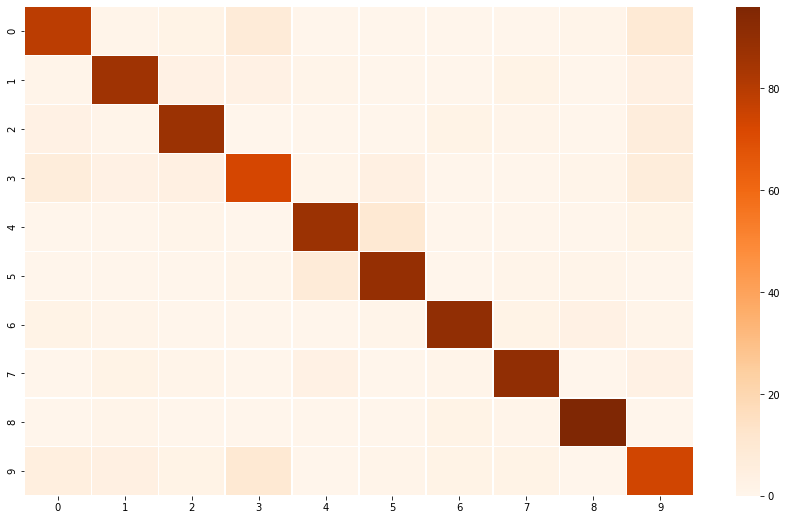

processing batch 2
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Starting epoch 1/70, LR = [2]
Step 0, Loss 0.09324315935373306
Step 50, Loss 0.02540072612464428
Starting epoch 2/70, LR = [2]
Step 100, Loss 0.029038965702056885
Starting epoch 3/70, LR = [2]
Step 150, Loss 0.025295712053775787
Starting epoch 4/70, LR = [2]
Step 200, Loss 0.02039908617734909
Starting epoch 5/70, LR = [2]
Step 250, Loss 0.021687639877200127
Starting epoch 6/70, LR = [2]
Step 300, Loss 0.019485892727971077
Starting epoch 7/70, LR = [2]
Step 350, Loss 0.019947737455368042
Starting epoch 8/70, LR = [2]
Step 400, Loss 0.01777396723628044
Starti

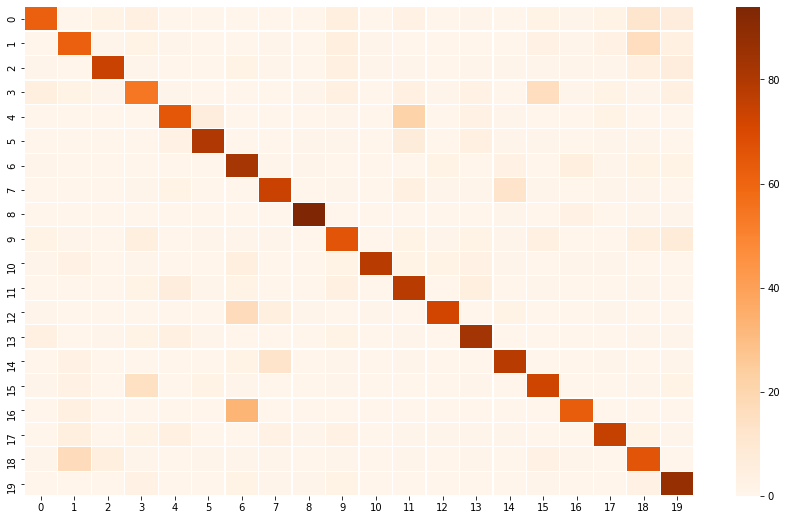

processing batch 3
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Starting epoch 1/70, LR = [2]
Step 0, Loss 0.0926702544093132
Step 50, Loss 0.03441615030169487
Starting epoch 2/70, LR = [2]
Step 100, Loss 0.029760979115962982
Starting epoch 3/70, LR = [2]
Step 150, Loss 0.028826534748077393
Starting epoch 4/70, LR = [2]
Step 200, Loss 0.02942841500043869
Starting epoch 5/70, LR = [2]
Step 250, Loss 0.028383126482367516
Starting epoch 6/70, LR = [2]
Step 300, Loss 0.02676551043987274
Starting epoch 7/70, LR = [2]
Step 350, Loss 0.02965950407087803
Starting epoch 8/70, LR = [2]
Step 400, Loss 0.024036824703216553
Starting

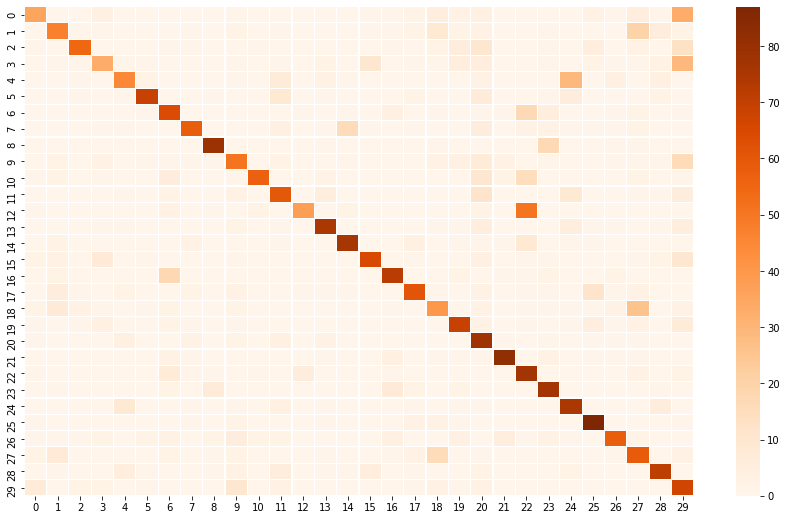

processing batch 4
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Starting epoch 1/70, LR = [2]
Step 0, Loss 0.10730802267789841
Step 50, Loss 0.04280291497707367
Starting epoch 2/70, LR = [2]
Step 100, Loss 0.043951570987701416
Starting epoch 3/70, LR = [2]
Step 150, Loss 0.03914831951260567
Starting epoch 4/70, LR = [2]
Step 200, Loss 0.037706028670072556
Starting epoch 5/70, LR = [2]
Step 250, Loss 0.03560581058263779
Starting epoch 6/70, LR = [2]
Step 300, Loss 0.04006502032279968
Starting epoch 7/70, LR = [2]
Step 350, Loss 0.03404289111495018
Starting epoch 8/70, LR = [2]
Step 400, Loss 0.03345085680484772
Starting 

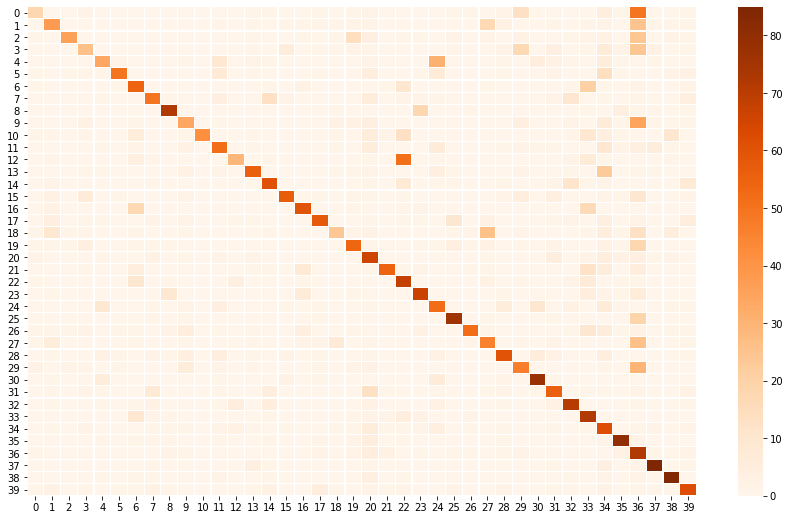

processing batch 5
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Starting epoch 1/70, LR = [2]
Step 0, Loss 0.12403145432472229
Step 50, Loss 0.05236548185348511
Starting epoch 2/70, LR = [2]
Step 100, Loss 0.04605921730399132
Starting epoch 3/70, LR = [2]
Step 150, Loss 0.04493109509348869
Starting epoch 4/70, LR = [2]
Step 200, Loss 0.04599887877702713
Starting epoch 5/70, LR = [2]
Step 250, Loss 0.04284472391009331
Starting epoch 6/70, LR = [2]
Step 300, Loss 0.04422171786427498
Starting epoch 7/70, LR = [2]
Step 350, Loss 0.04039224609732628
Starting epoch 8/70, LR = [2]
Step 400, Loss 0.042358703911304474
Starting e

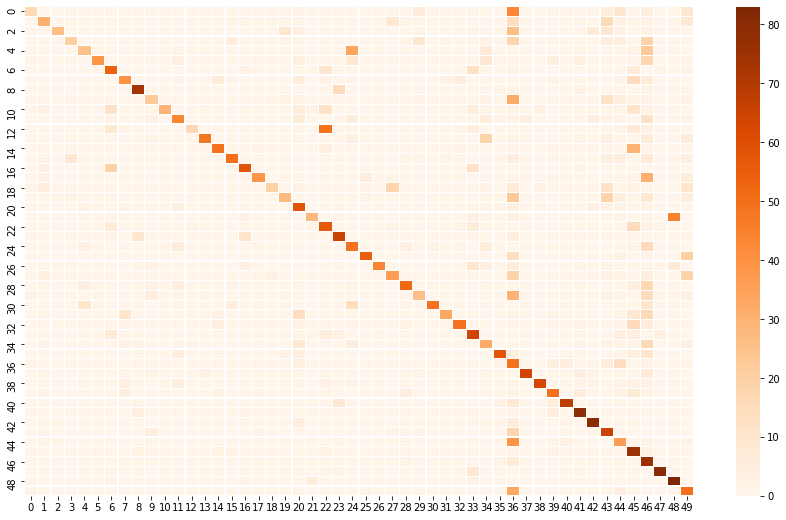

processing batch 6
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Starting epoch 1/70, LR = [2]
Step 0, Loss 0.12646682560443878
Step 50, Loss 0.056082405149936676
Starting epoch 2/70, LR = [2]
Step 100, Loss 0.052914056926965714
Starting epoch 3/70, LR = [2]
Step 150, Loss 0.05662570893764496
Starting epoch 4/70, LR = [2]
Step 200, Loss 0.05011213570833206
Starting epoch 5/70, LR = [2]
Step 250, Loss 0.04693593084812164
Starting epoch 6/70, LR = [2]
Step 300, Loss 0.04932871833443642
Starting epoch 7/70, LR = [2]
Step 350, Loss 0.0506826676428318
Starting epoch 8/70, LR = [2]
Step 400, Loss 0.04980622977018356
Starting e

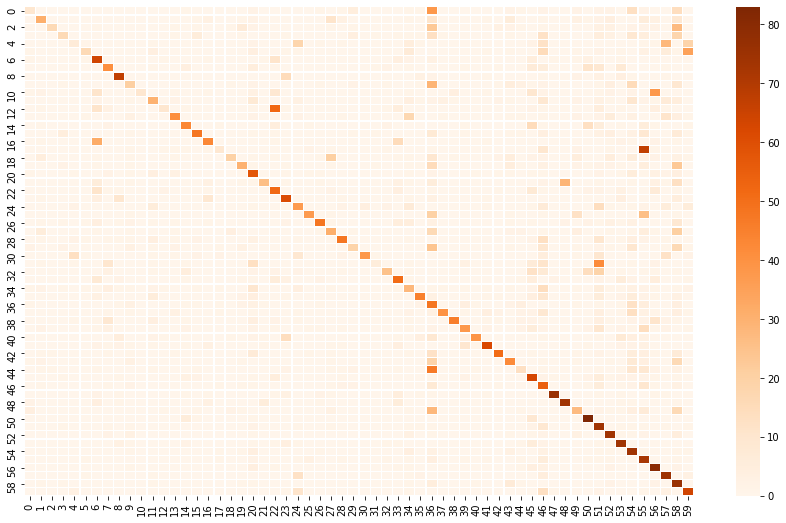

processing batch 7
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Starting epoch 1/70, LR = [2]
Step 0, Loss 0.12440933287143707
Step 50, Loss 0.05987797677516937
Starting epoch 2/70, LR = [2]
Step 100, Loss 0.06045037508010864
Starting epoch 3/70, LR = [2]
Step 150, Loss 0.057839009910821915
Starting epoch 4/70, LR = [2]
Step 200, Loss 0.06065681204199791
Starting epoch 5/70, LR = [2]
Step 250, Loss 0.05648929625749588
Starting epoch 6/70, LR = [2]
Step 300, Loss 0.05950264632701874
Starting epoch 7/70, LR = [2]
Step 350, Loss 0.05725885182619095
Starting epoch 8/70, LR = [2]
Step 400, Loss 0.05842941999435425
Starting e

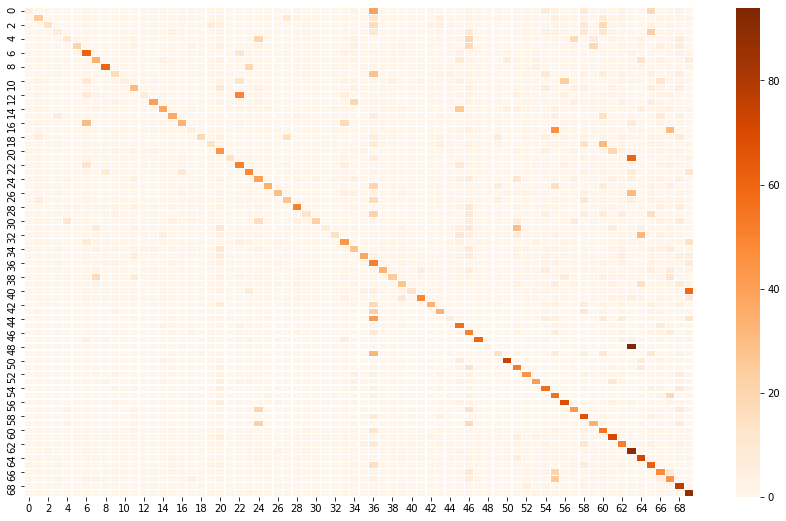

processing batch 8
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Starting epoch 1/70, LR = [2]
Step 0, Loss 0.12385161966085434
Step 50, Loss 0.06944543868303299
Starting epoch 2/70, LR = [2]
Step 100, Loss 0.06219969317317009
Starting epoch 3/70, LR = [2]
Step 150, Loss 0.06092744320631027
Starting epoch 4/70, LR = [2]
Step 200, Loss 0.06832107156515121
Starting epoch 5/70, LR = [2]
Step 250, Loss 0.06320341676473618
Starting epoch 6/70, LR = [2]
Step 300, Loss 0.06290695816278458
Starting epoch 7/70, LR = [2]
Step 350, Loss 0.06079822778701782
Starting epoch 8/70, LR = [2]
Step 400, Loss 0.06041824072599411
Starting ep

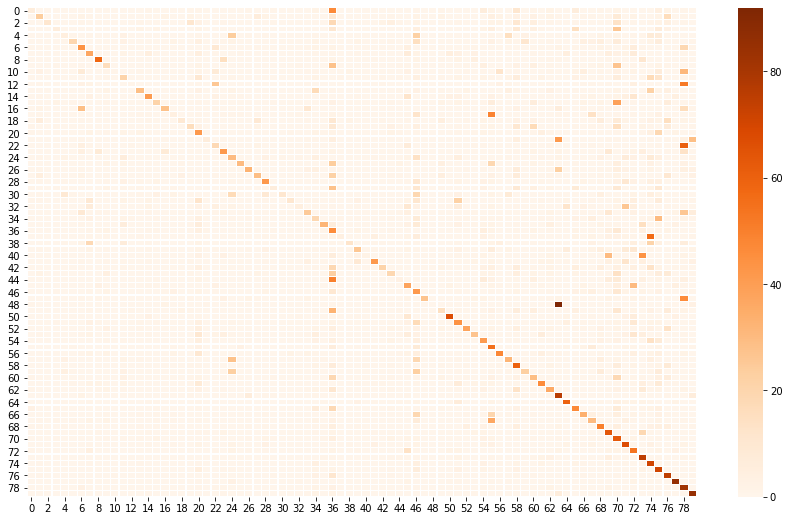

processing batch 9
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Starting epoch 1/70, LR = [2]
Step 0, Loss 0.1333187222480774
Step 50, Loss 0.07143130153417587
Starting epoch 2/70, LR = [2]
Step 100, Loss 0.06979266554117203
Starting epoch 3/70, LR = [2]
Step 150, Loss 0.07264615595340729
Starting epoch 4/70, LR = [2]
Step 200, Loss 0.06344309449195862
Starting epoch 5/70, LR = [2]
Step 250, Loss 0.06749764084815979
Starting epoch 6/70, LR = [2]
Step 300, Loss 0.06748392432928085
Starting epoch 7/70, LR = [2]
Step 350, Loss 0.06952495127916336
Starting epoch 8/70, LR = [2]
Step 400, Loss 0.07218264788389206
Starting epo

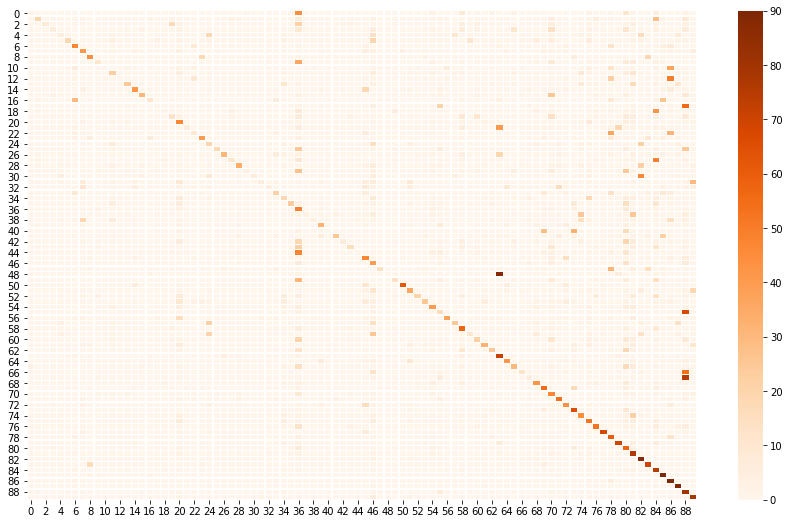

processing batch 10
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Starting epoch 1/70, LR = [2]
Step 0, Loss 0.13887237012386322
Step 50, Loss 0.0779600664973259
Starting epoch 2/70, LR = [2]
Step 100, Loss 0.07417690753936768
Starting epoch 3/70, LR = [2]
Step 150, Loss 0.0776580423116684
Starting epoch 4/70, LR = [2]
Step 200, Loss 0.07393777370452881
Starting epoch 5/70, LR = [2]
Step 250, Loss 0.07002571225166321
Starting epoch 6/70, LR = [2]
Step 300, Loss 0.07688477635383606
Starting epoch 7/70, LR = [2]
Step 350, Loss 0.07259204983711243
Starting epoch 8/70, LR = [2]
Step 400, Loss 0.07352344691753387
Starting epo

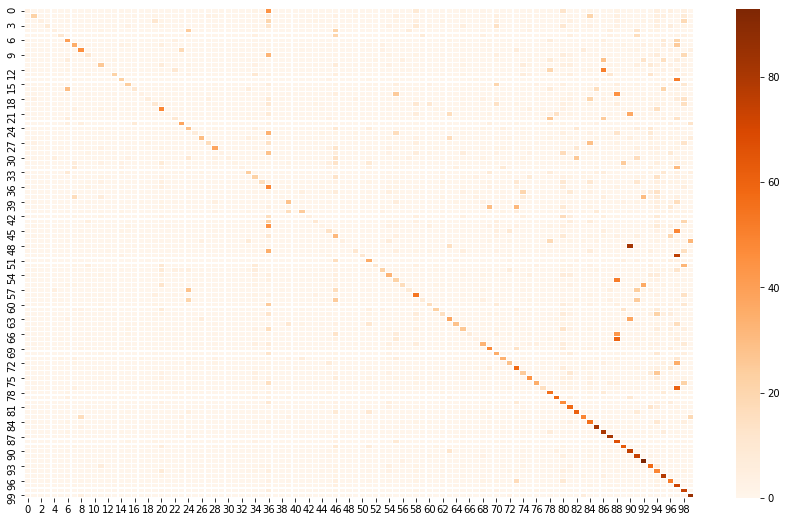

In [8]:
net = iCaRL()
K = 2000 # Memory Size
t = 0 # Number of classes
accuracies = [] # List of results 
test_dataset = CIFAR100_tError(DATA_DIR, train=False, transform=eval_transform, download=True)

for i in range(0,10): # batches of 10
  print(f"processing batch {i+1}")
  #Create Datasets
  train_datasets = []
  train_dataset_big = CIFAR100_tError(DATA_DIR, train=True, transform=train_transform, download=True)
  lbls, new_labels = make_data_labels(lbls) # take 10 new classes
  for label in new_labels:
    train_dataset = CIFAR100_tError(DATA_DIR, train=True, transform=eval_transform, download=True)
    train_dataset.increment([label],[t])
    test_dataset.increment([label],[t])
    train_dataset_big.increment([label],[t])
    train_datasets.append(train_dataset) # List of training examples in per class sets
    t += 1
  test_dataloader = DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=4)
  net.update_representation(train_dataset_big)
  m = K/t #numbers of exemplars per class
  matrix = new_confusion_matrix(lenx=t, leny=t)
  net.reduce_exemplar_sets(m)
  for X in train_datasets:
    print("Construct Exemplar")
    net.construct_exemplar_set(X,m) #new exemplar sets
    torch.no_grad()
    torch.cuda.empty_cache()
    gc.collect()
  # Test on Test set
  running_corrects = 0
  print("classifing")
  for images,labels in test_dataloader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)
    preds = net.classify(images)
    update_confusion_matrix(matrix, preds, labels)
    running_corrects += torch.sum(preds == labels.data).data.item()
    accuracy = running_corrects / float(len(test_dataset))
    del images
    del labels
    del preds
    torch.no_grad()
    torch.cuda.empty_cache()
    gc.collect()
  accuracies.append(accuracy)
  print(f"Test Accuracy: {accuracy}")
  show_confusion_matrix(matrix)

**Define plot function**

---



In [0]:
def accuracy_plot(accuracies):
  ### FOR MEAN STD PLOT https://stackoverflow.com/questions/22481854/plot-mean-and-standard-deviation
  from scipy import interpolate

  tck,u     = interpolate.splprep( [[i*10 for i in range(1,len(accuracies)+1)],accuracies] ,s = 0 )
  xnew,ynew = interpolate.splev( np.linspace( 0, 1, 100 ), tck,der = 0)

  fig, ax = plt.subplots(figsize=(15,14), facecolor='white')

  plt.rc('font', size=20)
  plt.plot( [i*10 for i in range(1,len(accuracies)+1)],accuracies,'.' , xnew ,ynew, label = "accuracy", c='orange' )
  ax.set_ylabel("Accuracy")
  ax.set_xlabel("Classes")
  ax.minorticks_on()
  #plt.title("Accuracies obtained with Icarl")
  plt.yticks(np.arange(0, 1.1, .1))
  plt.xticks(np.arange(0, 110, 10))
  plt.grid(axis='y',which='major', linestyle='-', linewidth='0.5', color='black') 
  plt.grid(axis='y',which='minor', linestyle=':', linewidth='0.5', color='grey')
  for in_i, in_j in zip([i*10 for i in range(1,len(accuracies)+1)], accuracies):  # Plot also the value of the point close to it
          ax.annotate(str(round(in_j, 3)), xy=(in_i, in_j))

  plt.savefig('test.png', format='png', dpi=300)
  plt.show()

*Print & Plot*

[0.851, 0.733, 0.627, 0.55425, 0.481, 0.43383333333333335, 0.38, 0.338875, 0.3268888888888889, 0.2984]


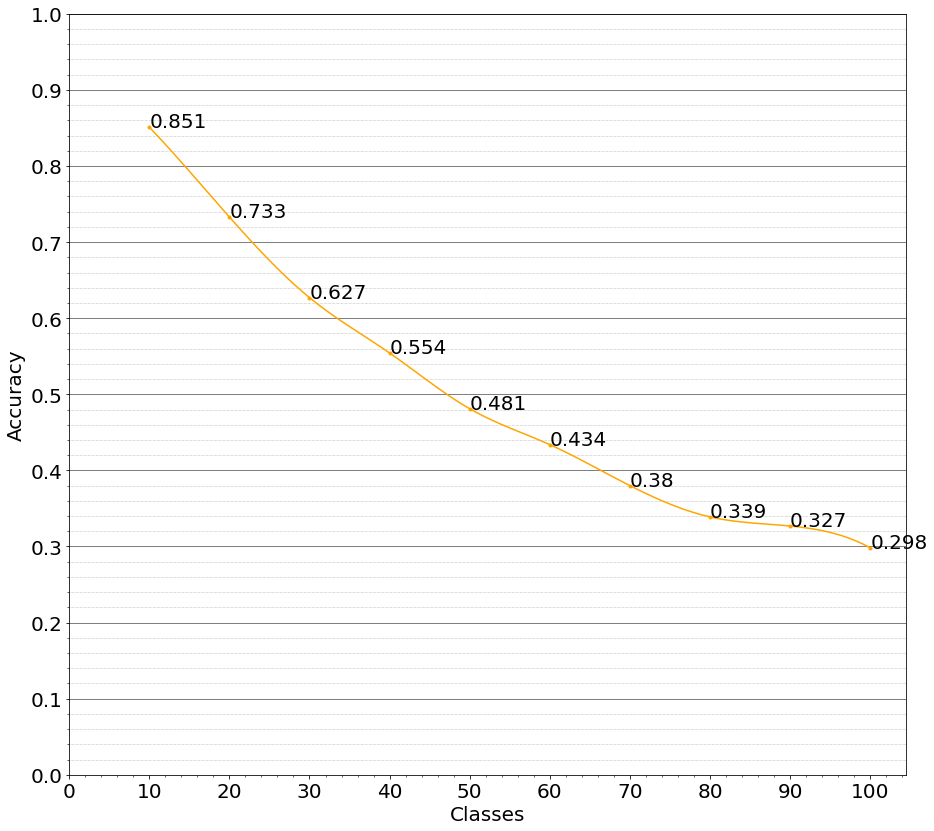

In [12]:
print(accuracies)

accuracy_plot(accuracies)
